# 层次聚类（Hierarchical Clustering）

## 1. 算法介绍

聚类（Clustering）是非监督学习（Unsupervised Learing）的一类重要的应用，旨在从数据中发现其隐藏的模式或结构，即数据探索的作用。传统的聚类分析算法可分为基于质心，分布，密度，连接等的算法，其中应用最多的kmean算法就是一种典型的基于质心的算法。但是kmeans算法需要提前指定k值，即类的数量，而不同的k值的聚类结果差异很大。层次聚类作为一种基于连接的算法，其优点在于用户无需提前指定类数，而且可以通过树状图解释聚类结果。

层次聚类的基本出发点在于：一个大类总可以分成多个小的子类，而子类又可以分成子类的子类，类似于生物学的系统树图。按照聚类方向，层次聚类可以分为**agglomerative**（自下而上）和**divisive**（自上而下）两种类型。在agglomerative方法中，每个样本开始都作为一个独立的类，每次合并最接近的两个类，直到最后只有一个类为止。而divisive则相反，开始时所有样本都属于一个大类，然后每次将其中一个大类分解成两个更小的子类，直到每个样本都成为一个子类。一般情况下，agglomerative方法的计算复杂度为$O(n^{2}\text{log}(n))$，而divisive的复杂度为$O(2^{n})$。本文仅介绍agglomerative的层次聚类方法。

![agglomerative-vs-divisive](img/1.png)

**Agglomerative clustering**算法主要分为以下X个步骤：

1. 对N个样本，初始化得到含有N个类的集合C，每个类有且仅有一个样本，即$c_{i} = \{x_{i}\}$
2. 找到最接近的两个类：$\text{min}D(c_{i}, c_{j})$
3. 合并上述两个最近的类$c_{i}, c_{j}$，得到新的大类$c_{i+j}$
4. 在集合C中移除已经合并的两个子类$c_{i}, c_{j}$
5. 重复2-5，直到C中仅有一个类

其中$x_{i}$为第$i$个样本，$c_{i}$为第i个类。

算法原理很简单，其中最重要的问题是如何定义接近，即需要一个距离的定义。 距离定义不同，聚类结果也不同。根据不同的距离，层次聚类可分为：

* single linkage (两个类中距离最近的两个样本间的距离)
* complete linkage （两个类中距离最远的两个样本间的距离）
* average linkage （两个类中所有样本的平均距离）

此外，还有Ward's linkage，V-linkage等其他方法。

## 2. 使用scipy进行层次聚类

In [55]:
# load library
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### 2.1 创建数据

In [56]:
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5,3]) * 10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.749239,7.979848,0.167205
ID_1,3.974831,6.683592,7.913526
ID_2,6.804410,1.455760,9.376617
ID_3,8.451248,8.327310,0.733414
ID_4,8.911886,6.400333,6.276996


上述代码创建了5个三维数据点，范围为[0, 10]。

### 2.2 使用scipy聚类：

In [57]:
from scipy.cluster.hierarchy import linkage

In [58]:
row_clusters = linkage(df.values,
        method='complete')
row_clusters

array([[  0.        ,   3.        ,   1.82706317,   2.        ],
       [  1.        ,   4.        ,   5.20893305,   2.        ],
       [  2.        ,   6.        ,   6.20466817,   3.        ],
       [  5.        ,   7.        ,  11.2862761 ,   5.        ]])

使用scipy提供的linkage可以方便地进行层次聚类，只需要提供需要进行聚类分析的样本数据（或者对应的距离矩阵），并且提供了多种聚类方法（包括"single", "complete", "average"等），用户可以根据需要选择不同的聚类方法。

linkage聚类结果是一个$(N-1) \times 4$的矩阵，每行代表第$i$次迭代的结果。前两列分别是第$i$次被合并的两类的index，生成的新类的index为$N+i$。第三列为被合并的这两类的距离，最后一列是合并得到的新类含有的样本数量。

用pandas的DataFrame可视化的结果如下：

In [59]:
pd.DataFrame(row_clusters,
            columns=['row label 1',
                     'row label 2',
                     'distance',
                     'no. of items in clust.'],
            index=['Iteration %d' % (i+1) for i in 
                   range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
Iteration 1,0.0,3.0,1.827063,2.0
Iteration 2,1.0,4.0,5.208933,2.0
Iteration 3,2.0,6.0,6.204668,3.0
Iteration 4,5.0,7.0,11.286276,5.0


因为我们有5个元素，所以初始cluster数量为5，其index分别是0-4，一共进行4次聚类迭代，最后得到含有5个样本的root cluster。聚类过程为：

* 第一次将0号和3号两个类进行合并，两个类的距离为1.34，得到的新类含有2个样本，index为5
* 第二次将4号和刚才得到的5号进行合并，类间距为2.50，得到的新类含有3个样本，index为6
* 第三次将1号和2号合并，类间距为3.02，得到的新类有2个样本，index为7
* 最后将6号和7号合并，类间距为8.77，得到的新类（即root cluster）有5个样本，index为8

### 2.3 Dendrogram可视化聚类过程

In [60]:
from scipy.cluster.hierarchy import dendrogram

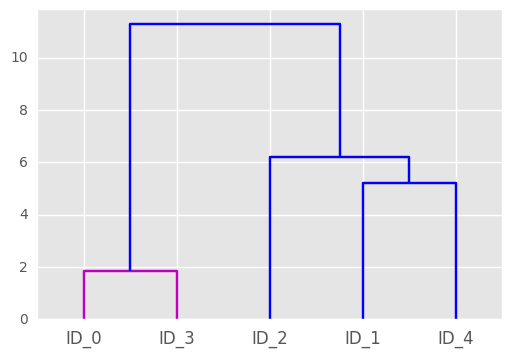

In [61]:
row_dendr = dendrogram(row_clusters,
                       labels=labels,
                       color_threshold=4)

上图横轴为叶节点（初始样本），纵轴为类间距。

通过scipy提供的dendrogram工具可以方便地可视化我们的聚类结果：上图横轴为叶节点（初始样本），纵轴为类间距。dendrogram还提供了多个参数定制化绘图结果。例如可以通过labels指定叶节点的文本，通过color_threshold指定颜色层次（例子中使用4的color_threshold，故类间距为4以下的类使用不同的颜色进行区分）。此外，还可以指定树状图方向，对图截断显示等。

## 3. 层次聚类实战

本小节我们使用层次聚类对真实数据进行聚类分析，使用的数据集是经典的iris。数据集包括setosa、versicolor和virginica三中花的花瓣（petal）长度和宽度以及萼片（sepal）的长度和宽度（均已厘米为单位），共150个样本。

In [62]:
# 首先load iris数据集
import seaborn as sns
sns.set()

iris = sns.load_dataset("iris")  # 载入数据
iris.iloc[:10]  # 显示前10个样本

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


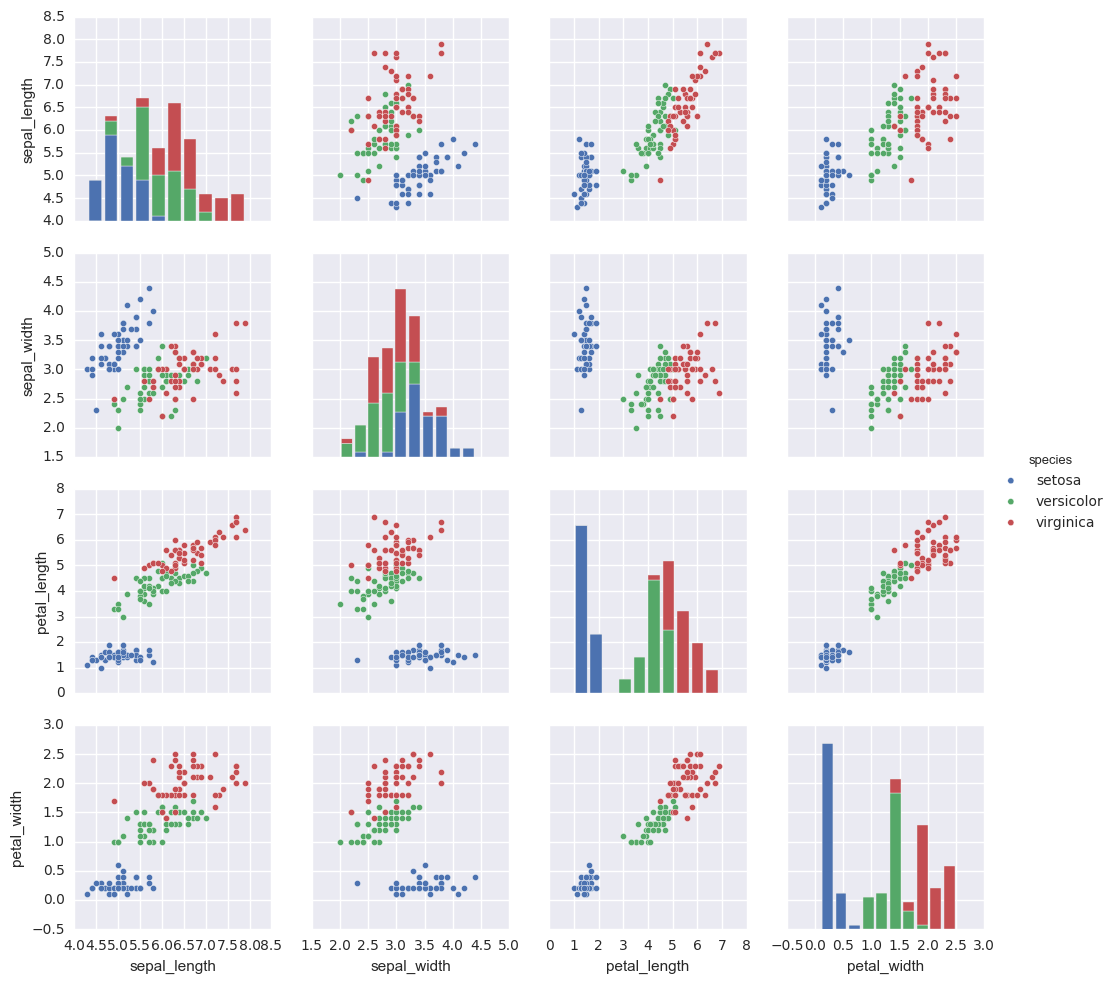

In [63]:
# 然后看一下样本数据分布情况
sns.pairplot(iris, hue="species")

从上图可以看出，setosa和另外两种花差别很明显，花瓣更短，更细。versicolor和virginica两种花在任意两个特征平面上均线性不可分，所以聚类算法可能把这两种花混淆。

首先试一下"single linkage"，直接调用scipy的linkage函数。

In [64]:
clusts = linkage(iris.values[:,0:4], 
                 method='single')

作dendrogram看一下分类结果。

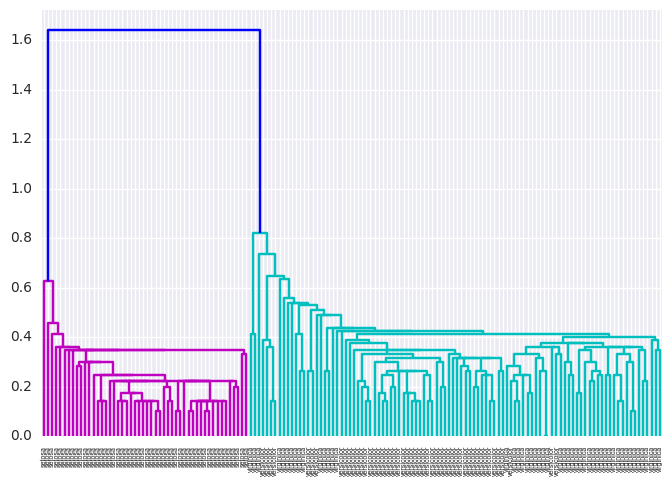

In [65]:
P = dendrogram(clusts, 
               labels=iris.values[:,4],
               orientation='top',
               )

类间距为0.8左右时可以得到3个类，下面通过指定类和叶节点颜色来更好地可视化分类结果。

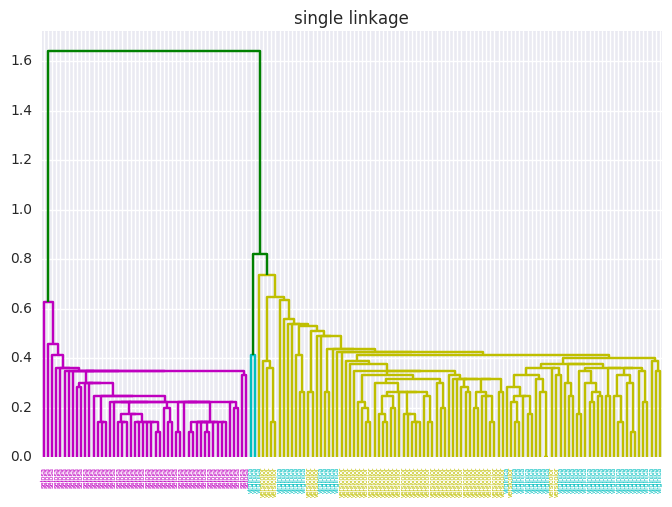

In [66]:
from scipy.cluster import hierarchy
hierarchy.set_link_color_palette(['m', 'c', 'y'])

# 绘制树状图
P = dendrogram(clusts, 
               labels=iris.values[:,4],
               orientation='top',
               above_threshold_color='g',
               color_threshold=0.8)

# 对叶节点label着色
label_colors = {'setosa': 'm', 'versicolor': 'y', 'virginica': 'c'}
ax = plt.gca()
ax.set_title('single linkage')
leaf_labels = ax.get_xmajorticklabels()
for leaf_label in leaf_labels:
    leaf_label.set_color(label_colors[leaf_label.get_text()])

如前面预料，setosa单独分为了一类，而另外两种花versicolor和virginica并没有很好地分开。下面我们尝试一下其他分类方法。

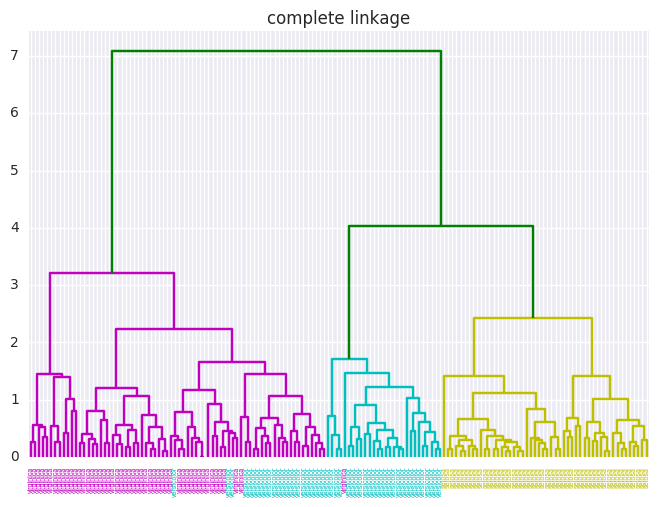

In [67]:
# complete linkage
clusts = linkage(iris.values[:,0:4], 
                 method='complete')

# 绘制树状图
P = dendrogram(clusts, 
               labels=iris.values[:,4],
               orientation='top',
               above_threshold_color='g',
               color_threshold=3.5)

# 对叶节点label着色
label_colors = {'setosa': 'y', 'versicolor': 'c', 'virginica': 'm'}
ax = plt.gca()
ax.set_title('complete linkage')
leaf_labels = ax.get_xmajorticklabels()
for leaf_label in leaf_labels:
    leaf_label.set_color(label_colors[leaf_label.get_text()])

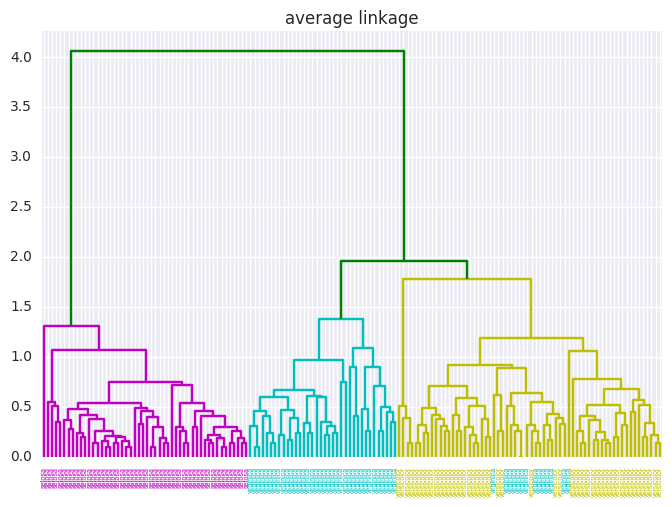

In [68]:
# average linkage
clusts = linkage(iris.values[:,0:4], 
                 method='average')

# 绘制树状图
P = dendrogram(clusts, 
               labels=iris.values[:,4],
               orientation='top',
               above_threshold_color='g',
               color_threshold=1.8)

# 对叶节点label着色
label_colors = {'setosa': 'm', 'versicolor': 'y', 'virginica': 'c'}
ax = plt.gca()
ax.set_title('average linkage')
leaf_labels = ax.get_xmajorticklabels()
for leaf_label in leaf_labels:
    leaf_label.set_color(label_colors[leaf_label.get_text()])

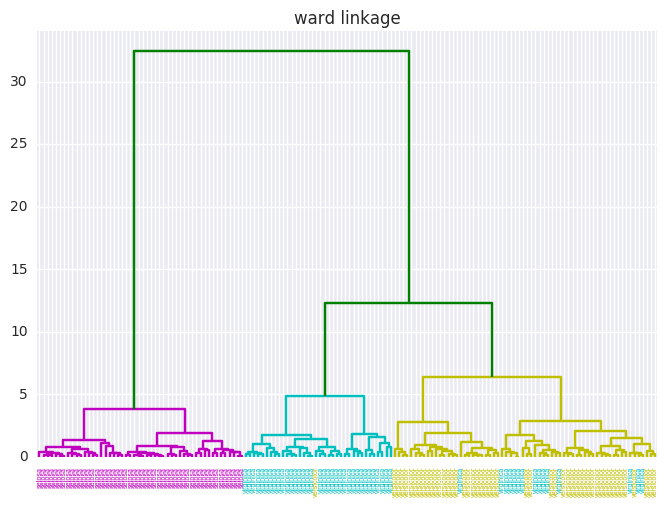

In [69]:
# ward linkage
clusts = linkage(iris.values[:,0:4], 
                 method='ward')

# 绘制树状图
P = dendrogram(clusts, 
               labels=iris.values[:,4],
               orientation='top',
               above_threshold_color='g',
               color_threshold=10)

# 对叶节点label着色
label_colors = {'setosa': 'm', 'versicolor': 'y', 'virginica': 'c'}
ax = plt.gca()
ax.set_title('ward linkage')
leaf_labels = ax.get_xmajorticklabels()
for leaf_label in leaf_labels:
    leaf_label.set_color(label_colors[leaf_label.get_text()])

上面我们尝试了single, complete, average和ward4种不同的linkage，从结果来看single最差，complete稍好一点，average和ward最好。

## 4. 参考资料

* [Python Machine Learning, Sebastian Raschka](https://www.amazon.com/Python-Machine-Learning-Sebastian-Raschka/dp/1783555130/ref=sr_1_sc_1?ie=UTF8&qid=1494753213&sr=8-1-spell&keywords=python+machine+leanring)
* [R Hierachical Clustering](https://cran.r-project.org/web/packages/dendextend/vignettes/Cluster_Analysis.html)
* [scipy-hierachical-clustering-and-dendrogram-tutorial](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)